<font size=6  color=#045fba> <b>[LINMA1702] - Modèles et méthodes d'optimisation I</b> <br><br> 
<b></b>Utilisation optimale d'une pompe à chaleur
domestique (première partie)</font> <br><br><br>

<font size=6  color=#045fba> <strong>Groupe 13 </strong></font> <br><br><br>


<font size=5  color=#045fba>
Simon Cornelis (<i>noma : 55101700</i>)<br>
Nicolas Jeanmenne (<i>noma : 48741900</i>)<br>
Corentin Libert (<i>noma : 53511700</i>)<br>
Aymeric Wibo (<i>noma : 74822100 </i>)<br>

<br><br>
</font>

# Tâche 1 : minimisation du coût total de l'électricité consommée par la pompe à chaleur

## Consignes
<br>
<font size=3>
<div class="alert alert-info">
On souhaite dans un premier temps que la température du bâtiment reste comprise dans une certaine plage admissible de températures, et on cherche à minimiser le coût total de l'électricité consommée par la pompe à chaleur. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le. <br>
    
Pour des raisons de temps de calcul, votre modèle considérera uniquement une période de 7 jours consécutifs. Il fera l'hypothèse que la température initiale au début de la période est égale à la valeur central de la plage admissible, et fera en sorte que la température finale à la fin de la période revienne à la même valeur. Votre code prendra donc en entrée un paramètre indiquant le numéro de l'intervalle de temps qui début la période, qui s'étendra sur $ 7 \times 24 \times 4 = 672$ intervalles de temps
</div>
</font>

<div class="alert alert-warning">
A mentionner :
    
    
- coût minimal + graphique de l'évolution des températures + graphique représentant
l'utilisation de la pompe à chaleur (en distinguant le fonctionnement normal du
fonctionnement _reverse_) + temps de calcul + bref commentaire (maximum 4 lignes
    
    
- pour deux périodes distinctes (placer les résultats côté à côté) : à gauche une période
pré-déterminée (cf. fichier de données), et à droite une seconde période que vous
choisirez en fonction de son intérêt
</div>

## Solution

### Variables

Nous avons différencié le mode **normal** du mode **reverse** en créant deux vecteurs $\mathbf{X_N} \in \mathbb{R}^{672}$ et $\mathbf{X_R} \in \mathbb{R}^{672}$, représentant respectivement la consommation en kWh de la pompe à chaleur pour un intervalle en mode **normal** et en mode **reverse**. 

Nous obtenons donc un total de $ 2 * 672 \text{ (c.f. consignes)} = 1344$ variables.

### Fonction objectif

Nous souhaitons minimiser le coût total de l'électricité consommée par la pompe à chaleur. Sous notation mathématique : 

$$ min \;\; (p*X_N + p*X_R) $$
Où: 
 - $p$ est le vecteurs des prix en fonction de la plage horaire des intervalles dans $X_N$ et $X_R$ (tarif bi-horaire: 0,18  $\$$/kWh ou 26 $\$$/kWh).
 - $X_N$ et $X_R$ sont définis comme dans la section [Variables](#Variables).
 
### Contraintes

Nous devons optimiser la fonction objectif sous les contraintes suivantes : 
- La consomation de la pompe à chaleur ne peut pas être inférieure à 0 kWh.
- La température intérieur (à la fin de chaque intervalle) doit se trouver dans la plage admissible $[T_{min}, T_{max}]$: 
$$ T_{min} \leq T_{int} \leq T_{max}$$
Le vecteur $T_{int}$ est calculé comme suit:
$$
\left\{
\begin{align} 
T_{int, i+1} &= t\_variation(T_{int, i}, T_{ext, i}) + 0.4 * cop_{normal, i+1} * X_{N, i+1} - 0.4 * cop_{reverse} * X_{R, i+1} \\
T_{int, 0} &= t\_variation(\frac{t_{max}+t_{min}}{2}, T_{ext, 0}) + 0.4 * cop_{normal, 0} * X_{N, 0} - 0.4 * cop_{reverse} * X_{R, 0}
\end{align}
\right.
$$
Où:
  * $t\_variation$ correspond à la fonction calculant la variation de la température intérieur en fonction de la température extérieur sur un intervalle.
  * $cop_{normal}$ est un vecteur reprenant les coefficient de performance pour le mode normal, basé sur la température extérieure
  * $cop_{reverse}$ est le coefficient de performance pour le mode reverse (constant).
  
$T_{int}$ prend donc en compte le futur, permettant par exemple, de chauffer plus la veille pendant les heures creuses en prévision d'une journée froide le lendemain.
- Nous devons ajouter une contrainte vérifiant que la consommation électrique totale maximale de la pompe à chaleur ne dépasse pas **1kWh**, soit **0.25kW par intervalle de 15 minutes**: $$ 0 \leq X_{N, i} + X_{R,i} \leq \frac{1}{4} \text{ kWh} $$

Ceci nous fait un total de $2 * (3 * 672) + 672 = 7 * 672$ contraintes, car, pour rappel, nous avons 2 vecteurs de 672 variables. Nous faisons comme hypothèse que la température initiale du premier intervalle de temps est dans la plage de température admissible (cf. consignes).

In [48]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

def get_end_temp(t_start, t_ext, eta=0.99):
    return (1 - eta) * (t_ext - t_start) + t_start

def get_end_interval_temperature(t_start, t_ext, eta=0.99):
    return (1 - eta) * (t_ext - t_start) + t_start

def get_cop(t_ext=None, mode='reverse', size=672):
    if(mode == 'reverse'):
        return np.array([3.2]*size)
    else:
        return 3 + 10 * np.abs(np.tanh(t_ext/100)) * np.tanh(t_ext/100)
        
def get_temp_data(data, index, size=672):
    return data[index:index+size]

def get_price_by_interval(index, size, p_peak, p_off_peak):
    prices = [p_off_peak]*28 + [p_peak]*60 + [p_off_peak]*8
    prices = prices[index % 96:] + prices[:index % 96]
    return prices * int(size/96)

def task1(data, index, size, t_min, t_max, p_peak, p_off_peak):
    # Problem data
    t_ext = get_temp_data(data, index, size)
    prices = get_price_by_interval(index, size, p_peak, p_off_peak)
    cop_n = get_cop(t_ext, 'normal', size)
    cop_r = get_cop(mode='reverse', size=size)
    
    # Variables
    Xn = cp.Variable(size)
    Xr = cp.Variable(size)
    T = cp.Variable(size)
    
    # Objectif
    objective = cp.Minimize(prices @ Xn + prices @ Xr)
    
    
    # Constraints
    constraints = [
        0 <= Xn,
        0 <= Xr,
        Xn + Xr <= 0.25,
        T[0] == get_end_temp((t_min + t_max)/2, t_ext[0]) + 0.4*cop_n[0] *Xn[0] - 0.4*cop_r* Xr[0]
    ]

    for i in range(size-1):
        constraints.append(T[i+1] == get_end_temp(T[i], t_ext[i+1]) + 0.4*cop_n[i+1]* Xn[i+1] - 0.4*cop_r* Xr[i+1])
    constraints.append(t_min <= T)
    constraints.append(T <= t_max)
    
    # Problem
    prob = cp.Problem(objective, constraints)
    
    # Solve
    start_time = time.time()
    result = prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return result, Xn, Xr, T, elapsed_time

def temperature_graph(T, index, size, t_min, t_max):
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(T)
    plt.axhline(y=t_max, color='r', linestyle='--', label='t_max')
    plt.axhline(y=t_min, color='r', linestyle='--', label='t_min')
    plt.title(f'Evolution de la température intérieure\n durant {size} intervalles de 15 minutes à partir de l\'intervalle {index}.')
    plt.xlabel('Intervalles (de 15 minutes)')
    plt.ylabel('Température (en °C)')
    plt.legend(loc=1, bbox_to_anchor=(1, 0.925))
    plt.show()
    
def pump_graph(Xn, Xr, index, size):
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(Xn, '-r', label='mode normal')
    plt.plot(Xr, '-b', label='mode reverse')
    plt.axhline(y=0.25, color='g', linestyle='--', label='consommation max\npar intervalle')
    plt.title(f'Utilisation de la pompe à chaleur\n durant {size} intervalles de 15 minutes à partir de l\'intervalle {index}.')
    plt.xlabel('Intervalles (de 15 minutes)')
    plt.ylabel('Consommation électrique (en kW par intervalle)')
    plt.legend(loc=1, bbox_to_anchor=(1, 0.925))
    plt.show()

In [49]:
import numpy as np

data_vector = np.load('data/Temperatures-Montreal.npy')
result, Xn, Xr, T, elapsed_time = task1(data_vector, 13050, 672, 19, 21, 0.26, 0.18)

In [57]:
print(f'Temps de calcul (en secondes) : {np.around(elapsed_time, 3)}')
print(f'Coût minimal (en $) : {np.around(result, 4)}')
print(f'Total Energie (en kWh) pour chauffer : {np.around(np.sum(Xn.value),3)}')
print(f'Total Energie (en kWh) pour refroidir : {np.around(np.sum(Xr.value),3)}\n')
print(f'Energie (en kWh) pour chauffer, par intervalle :\n{np.around(Xn.value, 3)}\n')
print(f'Energie (en kWh) pour refroidir, par intervalle :\n{np.around(Xr.value, 3)}')

Temps de calcul (en secondes) : 16.958
Coût minimal (en $) : 8.112
Total Energie (en kWh) pour chauffer : 38.629
Total Energie (en kWh) pour refroidir : 0.0

Energie (en kWh) pour chauffer, par intervalle :
[-0.    -0.    -0.    -0.    -0.    -0.    -0.     0.088  0.122  0.122
  0.128  0.128  0.128  0.128  0.135  0.135  0.135  0.185  0.25   0.25
  0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
  0.25   0.25   0.25   0.25  -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.     0.125  0.14   0.14   0.14   0.14
  0.14   0.14   0.14   0.14   0.137  0.137  0.137  0.137  0.131  0.131
  0.131  0.131  0.125  0.125  0.125  0.125  0.123  0.123  0.123  0.123
  0.119  0.119  0.119  0.119  0.114  0.114  0.114  0.114  0.107  0.107
  0.107  0.107  0.101  0.101  0.101  0.101  0.094  0.094  0.094  0.094
  0.09   0.09   0.09   0.09   0.084  0.084  0.084  0.084  0.082  0.082
  0.082  0.082  0.082  0.082  0.082  0.082  0.086  0.086  0.086  0.086
  0.088  0.088  0.

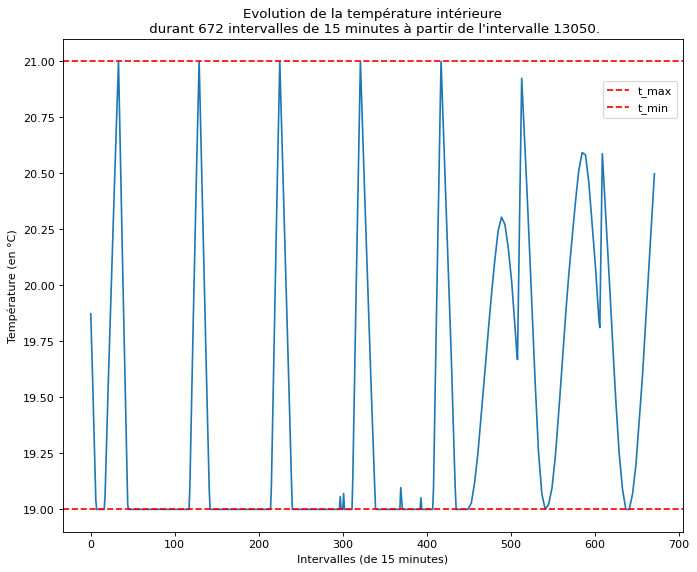

In [8]:
temperature_graph(T.value, 13050, 672, 19, 21)

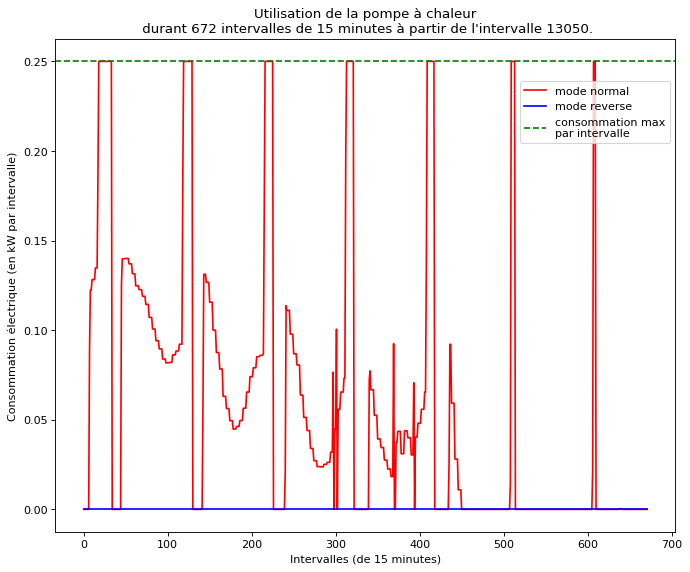

In [9]:
pump_graph(Xn.value, Xr.value, 13050, 672)

# Tâche 2 : minimisation de l'inconfort total

## Consignes
<br>
<font size=3>
<div class="alert alert-info">
On souhaite réduire le coût d'utilisation de la pompe à chaleur, et on va fixer le budget maximal à une certaine proportion du coût minimal identifié lors de la première tâche. Pour diminuer les coût, on va permettre aux températures de sortir de la plage admissible définie plus haut. On va cependant alors comptabiliser la quantité d'inconfort
éventuellement subi durant chaque intervalle de temps, qui sera proportionnel au dépassement de la température maximale admissible, ou au dépassement par le bas de la température minimale admissible. On cherche alors à <b>minimiser l'inconfort total</b> (somme des inconforts sur toute la période considérée) <b>tout en respectant la contrainte de budget</b>. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.
</div>
</font>

<div class="alert alert-warning">
A mentionner :
    
    
- inconfort minimal + même graphiques que pour tâche 1 + temps de calcul + bref
commentaire (maximum 4 lignes)
    
    
- à nouveau pour les deux périodes mentionnées lors de la tâche 1
</div>

In [52]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

def get_end_temp(t_start, t_ext, eta=0.99):
    return (1 - eta) * (t_ext - t_start) + t_start

def get_end_interval_temperature(t_start, t_ext, eta=0.99):
    return (1 - eta) * (t_ext - t_start) + t_start

def get_cop(t_ext=None, mode='reverse', size=672):
    if(mode == 'reverse'):
        return np.array([3.2]*size)
    else:
        return 3 + 10 * np.abs(np.tanh(t_ext/100)) * np.tanh(t_ext/100)
        
def get_temp_data(data, index, size=672):
    return data[index:index+size]

def get_price_by_interval(index, size, p_peak, p_off_peak):
    prices = [p_off_peak]*28 + [p_peak]*60 + [p_off_peak]*8
    prices = prices[index % 96:] + prices[:index % 96]
    return prices * int(size/96)

def task2(data, index, size, t_min, t_max, p_peak, p_off_peak, discomfort_bot, discomfort_top, budget_max):
    # Problem data
    t_ext = get_temp_data(data, index, size)
    prices = get_price_by_interval(index, size, p_peak, p_off_peak)
    cop_n = get_cop(t_ext, 'normal', size)
    cop_r = get_cop(mode='reverse', size=size)
    
    # Variables
    Xn = cp.Variable(size)
    Xr = cp.Variable(size)
    T = cp.Variable(size)
    
    # Objectif
    objective = cp.Minimize(
        cp.sum(cp.maximum(t_min - T, 0)) * discomfort_bot +
        cp.sum(cp.maximum(T - t_max, 0)) * discomfort_top
    )
    
    
    # Constraints
    constraints = [
        0 <= Xn,
        0 <= Xr,
        Xn + Xr <= 0.25,
        prices @ Xn + prices @ Xr <= budget_max,
        T[0] == get_end_temp((t_min + t_max)/2, t_ext[0]) + 0.4*cop_n[0] *Xn[0] - 0.4*cop_r* Xr[0]
    ]

    for i in range(size-1):
        constraints.append(T[i+1] == get_end_temp(T[i], t_ext[i+1]) + 0.4*cop_n[i+1]* Xn[i+1] - 0.4*cop_r* Xr[i+1])
    
    
    # Problem
    prob = cp.Problem(objective, constraints)
    
    # Solve
    start_time = time.time()
    result = prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
    end_time = time.time()
    elasped_time = end_time - start_time
    
    return result, Xn, Xr, T, elasped_time

def temperature_graph(T, index, size, t_min, t_max):
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(T)
    plt.axhline(y=t_max, color='r', linestyle='--', label='t_max')
    plt.axhline(y=t_min, color='r', linestyle='--', label='t_min')
    plt.title(f'Evolution de la température intérieure\n durant {size} intervalles de 15 minutes à partir de l\'intervalle {index}.')
    plt.xlabel('Intervalles (de 15 minutes)')
    plt.ylabel('Température (en °C)')
    plt.legend(loc=1, bbox_to_anchor=(1, 0.925))
    plt.show()
    
def pump_graph(Xn, Xr, index, size):
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(Xn, '-r', label='mode normal')
    plt.plot(Xr, '-b', label='mode reverse')
    plt.axhline(y=0.25, color='g', linestyle='--', label='consommation max\npar intervalle')
    plt.title(f'Utilisation de la pompe à chaleur\n durant {size} intervalles de 15 minutes à partir de l\'intervalle {index}.')
    plt.xlabel('Intervalles (de 15 minutes)')
    plt.ylabel('Consommation électrique (en kW par intervalle)')
    plt.legend(loc=1, bbox_to_anchor=(1, 0.925))
    plt.show()

In [55]:
import numpy as np

data_vector = np.load('data/Temperatures-Montreal.npy')
minimal_cost = 8.112
ratio = 9/10
result2, Xn2, Xr2, T2, elapsed_time2 = task2(data_vector, 13050, 672, 19, 21, 0.26, 0.18, 3, 1, minimal_cost*ratio)

In [58]:
print(f'Temps de calcul (en secondes) : {np.around(elapsed_time2, 3)}')
print(f'Inconfort minimal : {np.around(result2, 4)}')
print(f'Total Energie (en kWh) pour chauffer : {np.around(np.sum(Xn2.value),3)}')
print(f'Total Energie (en kWh) pour refroidir : {np.around(np.sum(Xr2.value),3)}\n')
print(f'Energie (en kWh) pour chauffer, par intervalle :\n{np.around(Xn2.value, 3)}\n')
print(f'Energie (en kWh) pour refroidir, par intervalle :\n{np.around(Xr2.value, 3)}')

Temps de calcul (en secondes) : 17.751
Inconfort minimal : 357.3243
Total Energie (en kWh) pour chauffer : 36.875
Total Energie (en kWh) pour refroidir : 0.0

Energie (en kWh) pour chauffer, par intervalle :
[-0.    -0.    -0.    -0.    -0.    -0.    -0.     0.088  0.122  0.122
  0.128  0.128  0.128  0.128  0.197  0.25   0.25   0.25   0.25   0.25
  0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
  0.25   0.25   0.25   0.25  -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.     0.14   0.14   0.14
  0.14   0.14   0.14   0.14   0.137  0.137  0.137  0.137  0.131  0.131
  0.131  0.131  0.125  0.125  0.125  0.125  0.123  0.123  0.123  0.123
  0.119  0.119  0.119  0.119  0.114  0.114 -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.    -0.
 -0.    -0.    -0.    -0.     0.25   0.25   0.25   0.25   0.25   0.25
  0.25   0.25   0.25   0.121  0.082  0.082  0.086  0.086  0.086  0.086
  0.088  0.088  0.088  0

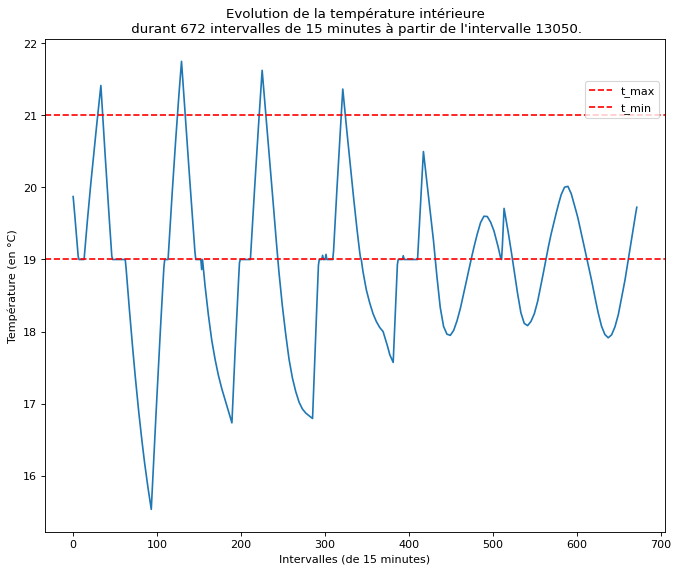

In [28]:
temperature_graph(T2.value, 13050, 672, 19, 21)

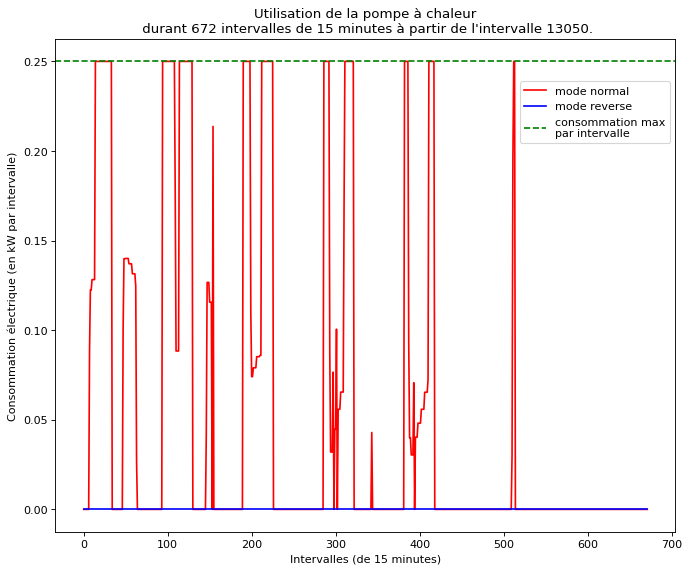

In [29]:
pump_graph(Xn2.value, Xr2.value, 13050, 672)

# Tâche 3 : relation entre budget et inconfort

## Consignes
<br>
<font size=3>
<div class="alert alert-info">
On voudrait à présent mieux comprendre le compromis qui existe entre le budget
alloué et l'inconfort total qui en résulte. Proposez un <b>graphique représentant au mieux
cette relation entre budget et inconfort</b>, où on fera varier le budget entre entre zéro et le
coût minimal identifié lors de la tâche 1 (ce budget sera indiqué en pourcentage, de 0 à
100%). Ceci nécessitera la résolution de plusieurs problèmes, et il sera judicieux d'utiliser la
    fonctionnalité <i>warm start</i> du solver pour accélérer les calculs.
</div>
</font>

<div class="alert alert-warning">
A mentionner :
    
    
- graphique demandé + temps de calcul (total et moyenne par problème) + bref
commentaire (maximum 4 lignes)
    
    
- à nouveau pour les deux périodes mentionnées lors des tâches 1 et 2
</div>

In [83]:
import numpy as np

def task3(data, index, size, t_min, t_max, p_peak, p_off_peak, discomfort_bot, discomfort_top, minimal_cost):
    # Problem data
    t_ext = get_temp_data(data, index, size)
    prices = get_price_by_interval(index, size, p_peak, p_off_peak)
    cop_n = get_cop(t_ext, 'normal', size)
    cop_r = get_cop(mode='reverse', size=size)
    
    # Variables
    Xn = cp.Variable(size)
    Xr = cp.Variable(size)
    T = cp.Variable(size)
    budget_max = cp.Parameter()
    
    # Objectif
    objective = cp.Minimize(
        cp.sum(cp.maximum(t_min - T, 0)) * discomfort_bot +
        cp.sum(cp.maximum(T - t_max, 0)) * discomfort_top
    )
    
    
    # Constraints
    constraints = [
        0 <= Xn,
        0 <= Xr,
        Xn + Xr <= 0.25,
        prices @ Xn + prices @ Xr <= budget_max,
        T[0] == get_end_temp((t_min + t_max)/2, t_ext[0]) + 0.4*cop_n[0] *Xn[0] - 0.4*cop_r* Xr[0]
    ]

    for i in range(size-1):
        constraints.append(T[i+1] == get_end_temp(T[i], t_ext[i+1]) + 0.4*cop_n[i+1]* Xn[i+1] - 0.4*cop_r* Xr[i+1])
    
    
    # Problem
    prob = cp.Problem(objective, constraints)
    
    # Results
    discomforts = []
    times = []
    
    # Solve
    for p in np.around(np.arange(1, -0.01, -0.01),2):
        budget_max.value = p*minimal_cost
        start_time = time.time()
        result = prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=True)
        end_time = time.time()
        elapsed_time = end_time - start_time
        discomforts.append(result)
        times.append(elapsed_time)
    
    discomforts.reverse()
    times.reverse()
    return discomforts, times
        

In [84]:
data_vector = np.load('data/Temperatures-Montreal.npy')
Ds, Times = task3(data_vector, 13050, 672, 19, 21, 0.26, 0.18, 3, 1, 8.112)

In [88]:
print(f'Temps de calcul total (en secondes) : {np.sum(np.array(Times))}')
print(f'Temps de calcul moyen (en secondes) : {np.mean(np.array(Times))}')

Temps de calcul total (en secondes) : 165.25239396095276
Temps de calcul moyen (en secondes) : 1.636162316445077


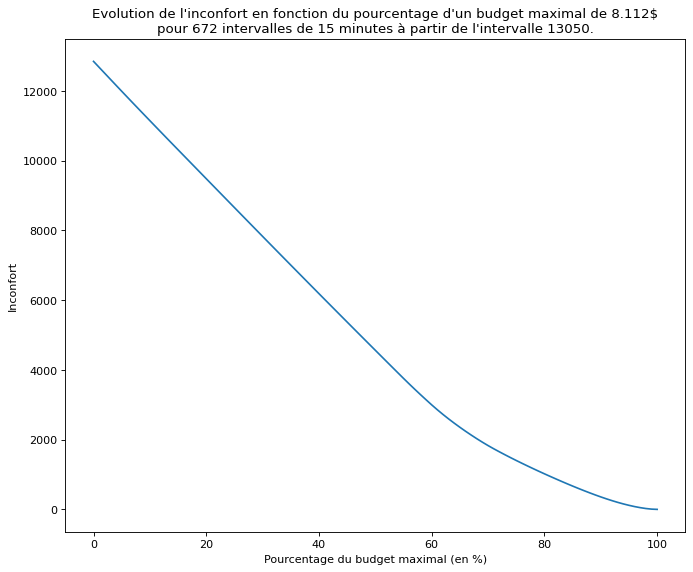

In [82]:
def discomfort_graph(discomfort, minimal_cost, index, size):
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(discomfort)
    plt.title(f'Evolution de l\'inconfort en fonction du pourcentage d\'un budget maximal de {minimal_cost}$\n' + 
              f'pour {size} intervalles de 15 minutes à partir de l\'intervalle {index}.')
    plt.xlabel('Pourcentage du budget maximal (en %)')
    plt.ylabel('Inconfort')
    plt.savefig('graphs/task3_discomfort_graph.png')
    plt.show()
    
discomfort_graph(Ds, 8.112, 13050, 672)